In [1]:
import numpy as np

from statespace.models import NVMLangevinModel
from primitives.levyprocess import GammaProcess

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from primitives.linalg import invert_covariance

In [3]:
T = np.linspace(0, 100, num=500).reshape(-1, 1)

In [4]:
gamma_process_params = {"beta":5., "C":5.}
subordinator = GammaProcess(**gamma_process_params)

In [5]:
langevin_model = NVMLangevinModel(subordinator=subordinator, theta=-2., mu=0., sigma=1., sigma_eps=0.01, shape=(2,1))

In [6]:
x, y = langevin_model.sample(times=T)

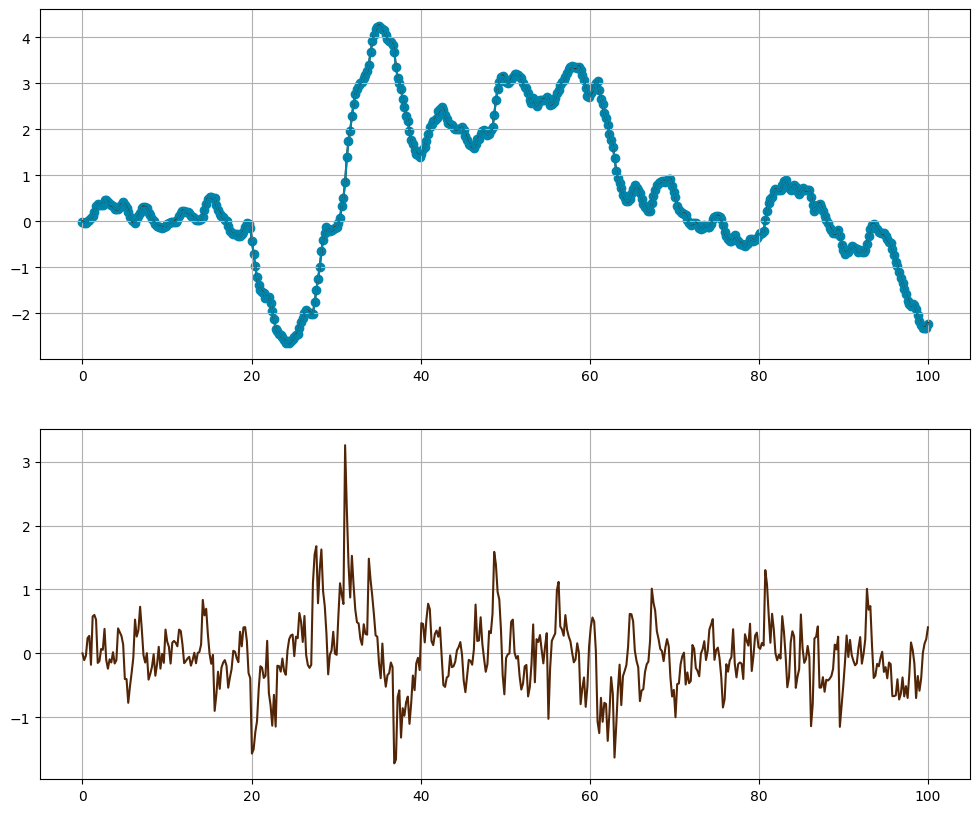

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

In [8]:
langevin_model.get_parameter_values()

{'theta': -2.0, 'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.01}

In [10]:
x.shape

(500, 2, 1)

In [12]:
y.shape

(500, 1, 1)

In [18]:
T.shape

(500, 1)

In [55]:
# Kalman filter:
D = 2
N = T.shape[0]

In [56]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=1., size=(D, 1))

P_init = np.random.normal(loc=0., scale=1., size=(D, D))
P_init = np.matmul(P_init.T, P_init)

# Initialise estimate
x_est = np.zeros(shape=(N+1, x_init.shape[0], 1))
x_pred = np.zeros(shape=(N, x_init.shape[0], 1))

P_est = np.zeros(shape=(N+1, P_init.shape[0], P_init.shape[1]))
P_pred = np.zeros(shape=(N, P_init.shape[0], P_init.shape[1]))

x_est[0] = x_init
P_est[0] = P_init

In [57]:
T_input = np.vstack((0, T))

In [58]:
H = np.zeros((1,2))
H[0][0] = 1

R = np.array([[0.01]])

In [59]:
# Start iterations:

for i, t in enumerate(T, 1):

    A = langevin_model.expA(t-T_input[i-1])
    noise_mean, Q = langevin_model.I.conditional_moments(s=T_input[i-1], t=t)

    # Predict:
    x_pred[i-1] = A @ x_est[i-1] + noise_mean
    P_pred[i-1] = A @ P_est[i-1] @ A.T + Q

    # Update:
    residual_pred = y[i-1] - H @ x_pred[i-1]
    residual_pred_cov = H @ P_pred[i-1] @ H.T + R
    kalman_gain = P_pred[i-1] @ H.T @ invert_covariance(residual_pred_cov)

    x_est[i] = x_pred[i-1] + kalman_gain @ residual_pred
    P_est[i] = (np.eye(D) - kalman_gain @ H) @ P_pred[i-1]

In [77]:
vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])

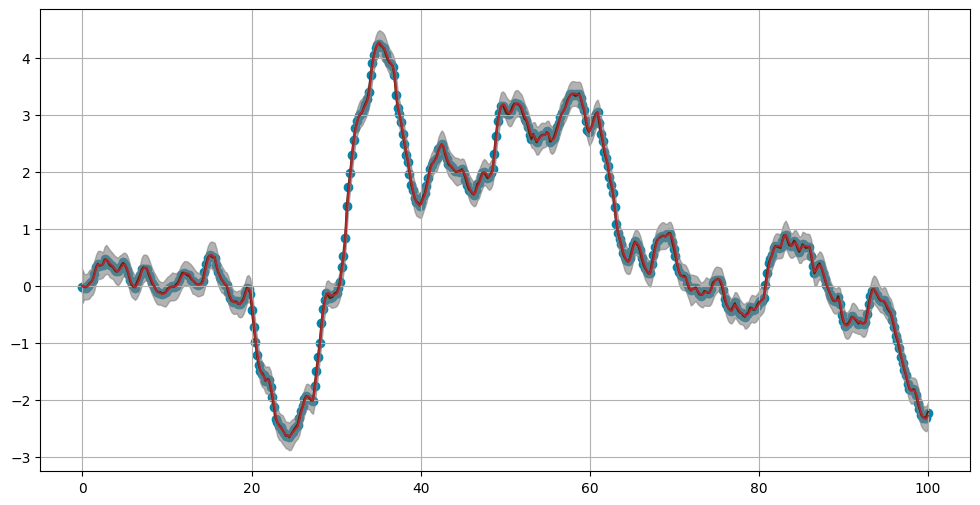

In [83]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(T, x[:,0,:], color="#522506")
ax.scatter(T, y[:,0,:], color="#0085ad")
#ax.plot(t, y[:,0,:], color="#0085ad")

ax.plot(T, x_est[1:,0,:], color="#AF272F")
ax.fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)
ax.fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(vars[:, 0]), color='grey', alpha=0.6)

ax.grid(True)

plt.show()

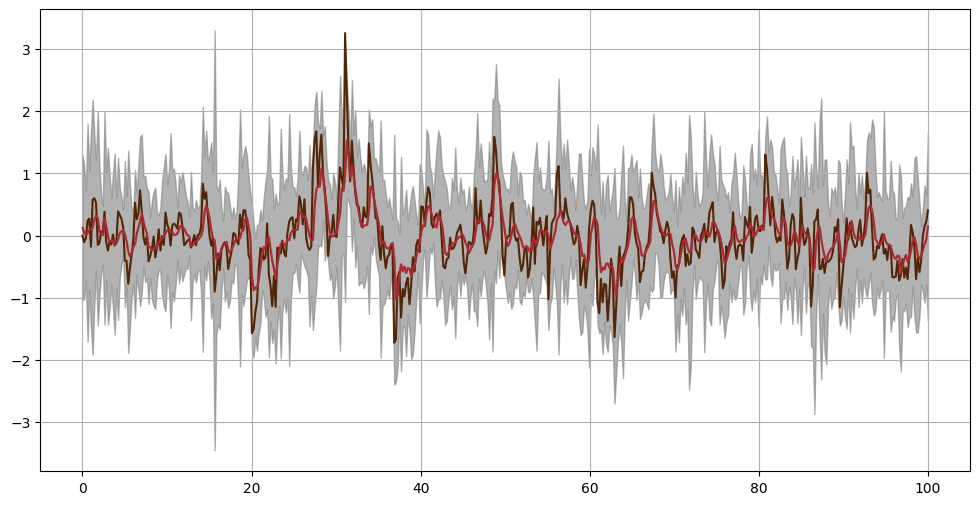

In [84]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(T, x[:,1,:], color="#522506")
#ax.plot(t, y[:,0,:], color="#0085ad")

ax.plot(T, x_est[1:,1,:], color="#AF272F")

ax.fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)
ax.fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(vars[:, 1]), color='grey', alpha=0.6)

ax.grid(True)

plt.show()